# Lab 2

## Warm Up Questions

### State-Space Modelling of a Linear Time-Invariant System
1. Explain the defining properties of a linear time-invariant (LTI) state-space system. How does the modelling process differ when the system is nonlinear instead of linear?

A cart moves along a horizontal track. We would like to track the desired position with input to the velocity.  
We compute the dynamics and integrate this into a state-space model that is linear time invariant.

2. Derive the state-space equations and write them as a state-space representation.

The dynamics include friction, which is an opposing force proportional to velocity.  
From Newton’s 2nd law we have:

- Force balance:  
  $F = m a$

- Applied force with friction:  
  $m \ddot{x}(t) = u(t) - b \dot{x}(t)$
  where $b$ is a constant describing friction.

We take:
- $x$ as the position
- $\dot{x} = v$ as the velocity

Rearranging the dynamic equation gives:
$$m \ddot{x}(t) = u(t) - b \dot{x}(t).$$

Now convert to state-space form:

Let the state be:
- $x_1 = x$
- $x_2 = v = \dot{x}$

Then:
- $x_1' = x_2$
- $x_2' = \dfrac{1}{m} u(t) - \dfrac{b}{m} x_2$

Write the system in matrix form to obtain the matrices $A$ and $B$.


In [775]:
import numpy as np
import matplotlib.pyplot as plt

In [776]:
#Parameters
m = 10
b=0.5

In [777]:
#TODO Write the state space representation matrices A, B and C
A = np.array([
    [0.0,        1.0],
    [0.0, -b / m]
])

B = np.array([
    [0.0],
    [1.0 / m]
])

C = np.array([
    [1.0, 0.0],  # output 1 = position
    [0.0, 1.0]   # output 2 = velocity
])


## Simulation Settings

In [778]:
dt = 0.01
T = 10.0
N = int(T/dt)
t = np.linspace(0.0,T, N+1)

#Now apply an input to the system, this could be a pulse foce or a constant
u = np.zeros(N+1)
u[(t>=1)&(t<=3)] = 1
u[(t>=5)&(t<=8)] = 2

x = np.zeros((N+1, 2))
y = np.zeros((N+1,2))

x[0,:] = np.array([0,0])
#TODO Write a loop for the state in the form of x_dot = A x + B u for the position and the velocity
for k in range(N):
    xk = x[k, :].reshape(2,1)
    uk = u[k]

    xdot = A @ xk + B * uk

    
    x[k+1, :] = (xk + dt * xdot).flatten()

    y[k, :] = (C @ xk).flatten()

y[-1, :] = (C @ x[-1, :].reshape(2, 1)).flatten()

p = y[:,0]
v = y[:,1]


Now plot the results of the position and velocity

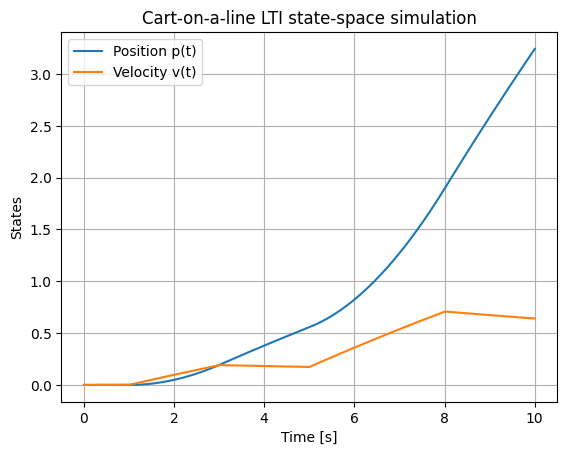

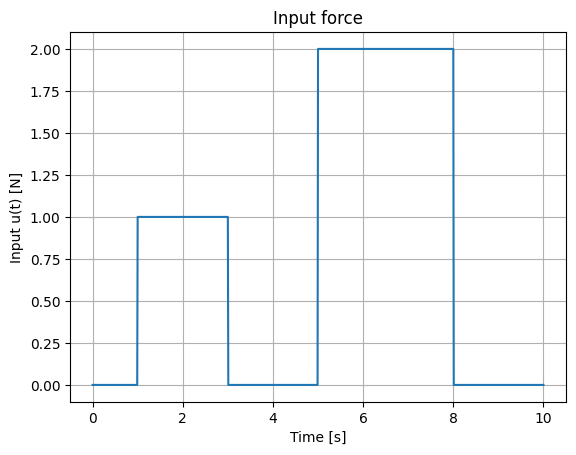

In [779]:
plt.figure()
plt.plot(t, p, label='Position p(t)')
plt.plot(t, v, label='Velocity v(t)')
plt.xlabel('Time [s]')
plt.ylabel('States')
plt.title('Cart-on-a-line LTI state-space simulation')
plt.grid(True)
plt.legend()

plt.figure()
plt.plot(t, u)
plt.xlabel('Time [s]')
plt.ylabel('Input u(t) [N]')
plt.title('Input force')
plt.grid(True)

plt.show()

We now change to a linear time varying model. This is done through imagine the cart's mass decreases over time due to burning it's fuel

In [780]:
#Mass function, this is the mass decreasing over time
def mass_function(t):
    return m - np.log(t)

In [781]:
# Apply force
u = np.zeros(N+1)
for i, value in enumerate(u):
    if i <5:
        u[i] = 1
    else:
        u[i] = 2



In [782]:
x = np.zeros((N+1,2))
y = np.zeros((N+1,2))

x[0,:] = np.array([0,0])

for k in range(N):
    tk = t[k]
    xk = x[k,:].reshape(2,1)
    uk = u[k]
    mk = mass_function(tk)
    A = np.array([
        [0.0,        1.0],
        [0.0, -b / mk]
    ])

    B = np.array([
        [0.0],
        [1.0 / mk]
    ])
    C = np.array([
    [1.0, 0.0],  # output 1 = position
    [0.0, 1.0]   # output 2 = velocity
    ])
    xdot = A@xk +B*uk
    x[k+1,:] = (xk+dt*xdot).flatten()
    y[k,:] = C@x[k,:].flatten()
y[-1, :] = C@x[-1,:].reshape(2,1).flatten()
p_ltv = y[:,0]
v_ltv = y[:,1]




/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_99463/24704523.py:3: RuntimeWarning: divide by zero encountered in log
  return m - np.log(t)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_99463/24704523.py:3: RuntimeWarning: divide by zero encountered in log
  return m - np.log(t)


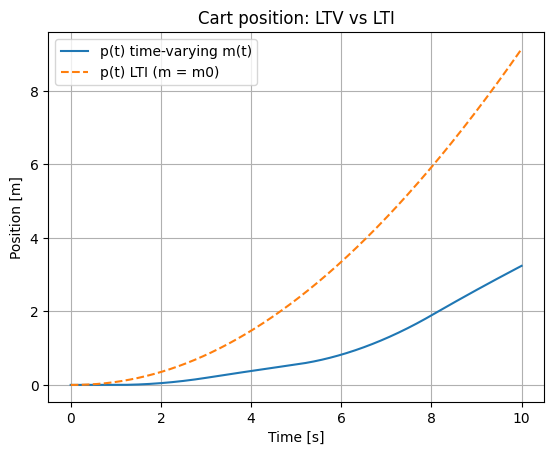

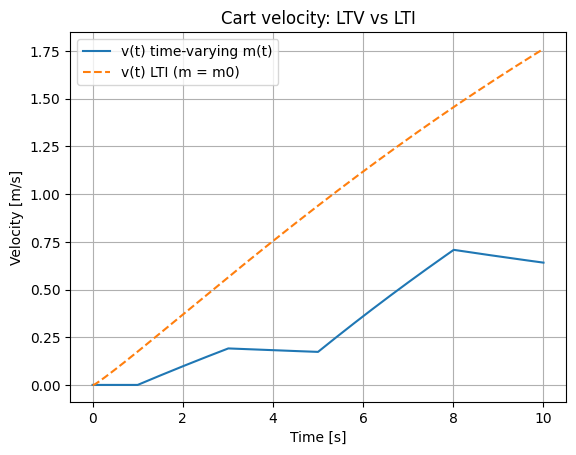

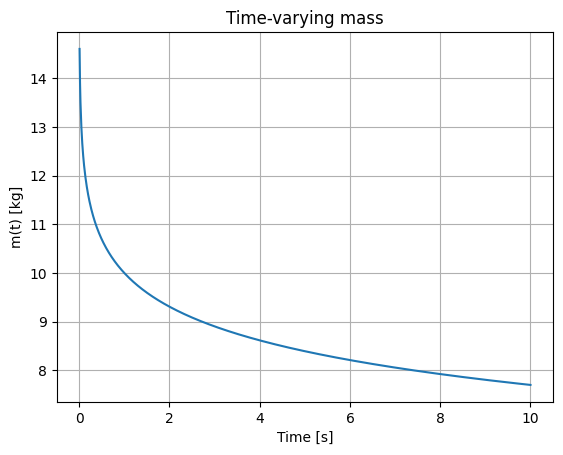

In [783]:
plt.figure()
plt.plot(t, p, label='p(t) time-varying m(t)')
plt.plot(t, p_ltv, '--', label='p(t) LTI (m = m0)')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Cart position: LTV vs LTI')
plt.grid(True)
plt.legend()

plt.figure()
plt.plot(t, v, label='v(t) time-varying m(t)')
plt.plot(t, v_ltv, '--', label='v(t) LTI (m = m0)')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.title('Cart velocity: LTV vs LTI')
plt.grid(True)
plt.legend()

m_vals = mass_function(t)
plt.figure()
plt.plot(t, m_vals)
plt.xlabel('Time [s]')
plt.ylabel('m(t) [kg]')
plt.title('Time-varying mass')
plt.grid(True)

plt.show()


We add noise to the trajectory

In [784]:

sigma_v_p = 1e-1  
sigma_v_v = 1e-2 


In [785]:
meas_dt = 0.01                      
meas_stride = int(meas_dt / dt)  
y_true = y 
rng = np.random.default_rng(seed=0)
y_meas = np.full_like(y_true, np.nan)   

for k in range(N+1):
    if k % meas_stride == 0:
        noise = rng.normal(
            loc=[0.0, 0.0],
            scale=[sigma_v_p, sigma_v_v]
        )
        y_meas[k, :] = y_true[k, :] + noise
    else:
        pass


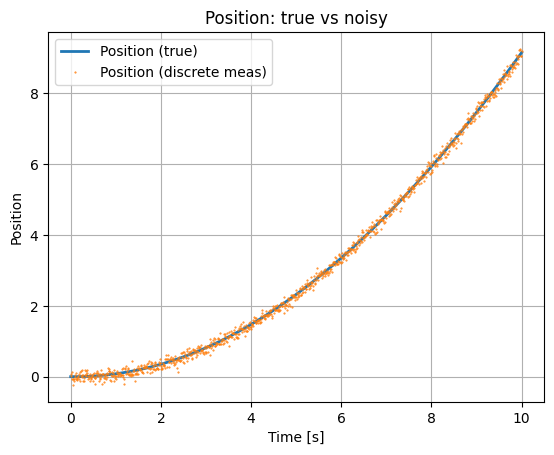

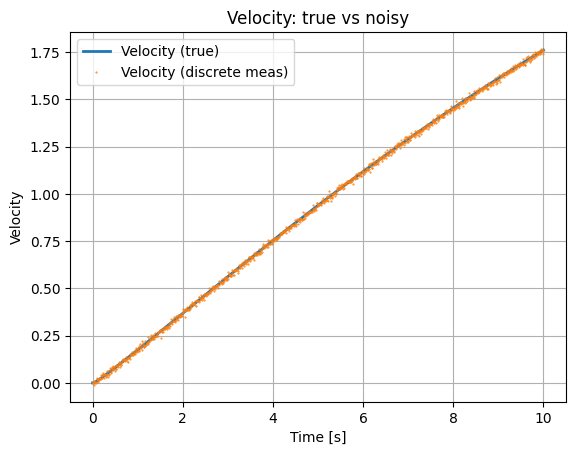

In [786]:

p_true = y_true[:, 0]
v_true = y_true[:, 1]


p_meas = y_meas[:, 0]
v_meas = y_meas[:, 1]

mask_p = ~np.isnan(p_meas)
mask_v = ~np.isnan(v_meas)


plt.figure()
plt.plot(t, p_true, label='Position (true)', linewidth=2)
plt.plot(t[mask_p], p_meas[mask_p], 'o', label='Position (discrete meas)', markersize=0.5)

plt.xlabel('Time [s]')
plt.ylabel('Position')
plt.title('Position: true vs noisy')
plt.grid(True)
plt.legend()


plt.figure()
plt.plot(t, v_true, label='Velocity (true)', linewidth=2)
plt.plot(t[mask_v], v_meas[mask_v], 'o', label='Velocity (discrete meas)', markersize=0.5)

plt.xlabel('Time [s]')
plt.ylabel('Velocity')
plt.title('Velocity: true vs noisy')
plt.grid(True)
plt.legend()

plt.show()


# Kalman Filter

Study the proof of the Recursive Least Squares (RLS) Kalmian gain to answer the following questions.

1. Why is the cost function chosen as  
   $W_k = \operatorname{tr}(P_k)$ ?  
   What is the physical meaning of minimizing the trace of the covariance?

2. Explain why the cross term  
   $E[e_{k-1} v_k^\top]$  
   equals zero in the derivation and what assumptions about the noise $v_k$ are necessary for the derivation?

3. Why does the RLS covariance always decrease over time?




In [787]:
class KalmanFilter(object):
    #Here we build a Kalman Filter which we will then implement for our state space model
    def __init__(self, x0, P0, A, B, C, Q, R):
        #Here we set up the class with the vectors and matrices
        self.x0 = x0
        self.P0 = P0
        self.A = A
        self.B = B
        self.C = C
        self.Q = Q
        self.R = R
        self.time_step = 0
        #This list will store the results so we can use them throughout the implementation
        self.aposteriori = [x0]
        self.apriori = []
        self.Cmatrixaposteriori = [P0]
        self.Cmatrixapriori = []
        self.Kmatrix = []
        self.error = []

    def set_matrices(self, A, B, C):
        #This is implemented for the time-varying model
        self.A = A
        self.B = B
        self.C = C

    def push_dynamics(self, control_input):
        #TODO Implement a function which computes x_k minus and P_k minus and then append these to apriori and apriori covariance matrix
        xk_plus = self.aposteriori[self.time_step]
        Pk_plus = self.Cmatrixaposteriori[self.time_step]    
        xk_minus = self.A @ xk_plus + self.B * control_input
        Pk_minus = self.A @ Pk_plus @ self.A.T + self.Q

        self.apriori.append(xk_minus)
        self.Cmatrixapriori.append(Pk_minus)

        self.time_step +=1
    def Aposteriori_estimate(self, measurement):
        #TODO Implement a function that computes the Kalman Gain
        #update estimate, update covariance. Then save these into the Kmatrix, error_k, aposteriori and Cmatrixaposteriori
        P_minus = self.Cmatrixapriori[self.time_step-1]
        x_minus = self.apriori[self.time_step-1]

        S = self.C @P_minus@self.C.T + self.R
        k_gain = P_minus@self.C.T@np.linalg.inv(S)

        error_k = measurement - self.C@x_minus

        xk_plus = x_minus + k_gain@error_k
        I = np.eye(self.x0.shape[0])
        Pk_plus = (I-k_gain@self.C) @ P_minus

        self.Kmatrix.append(k_gain)
        self.error.append(error_k)
        self.aposteriori.append(xk_plus)
        self.Cmatrixaposteriori.append(Pk_plus)

    def update_if_measurement(self, measurement):
        if measurement is None:
            self.aposteriori.append(self.apriori[-1])
            self.Cmatrixaposteriori.append(self.Cmatrixapriori[-1])
            return
        self.Aposteriori_estimate(measurement)


In [788]:

x0 = np.array([[0.0],[0.0]])          # initial [p, v]
P0 = np.diag([1.0, 1.0])              # initial uncertainty

Q = np.diag([ (1e-3)**2, (1e-2)**2 ]) # process Noise
R = np.diag([ (1e-2)**2, (1e-2)**2 ]) # measurement noise

C = np.array([[1., 0.],
              [0., 1.]]) #  position & velocity

# Kalman Filter class creation
kf = KalmanFilter(x0, P0, None, None, C, Q, R)


x_hat = np.zeros((N+1, 2))
x_hat[0,:] = x0.flatten()
P = np.zeros((N+1, 2, 2))
P[0,:,:] = P0

for k in range(N):

    tk = t[k]
    uk = u[k]

    mk = mass_function(tk)

    A_c = np.array([[0.0,      1.0],
                    [0.0, -b/mk]])

    B_c = np.array([[0.0],
                    [1.0/mk]])

    A_d = np.eye(2) + dt * A_c
    B_d = dt * B_c

    kf.set_matrices(A_d, B_d, C)

    # predict
    kf.push_dynamics(uk)

    # update
    if np.isnan(y_meas[k+1,0]):
        kf.update_if_measurement(None)
    else:
        meas = y_meas[k+1,:].reshape(2,1)
        kf.update_if_measurement(meas)

    x_hat[k+1,:] = kf.aposteriori[-1].flatten()
    P[k+1,:,:] = kf.Cmatrixaposteriori[-1]


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_99463/24704523.py:3: RuntimeWarning: divide by zero encountered in log
  return m - np.log(t)


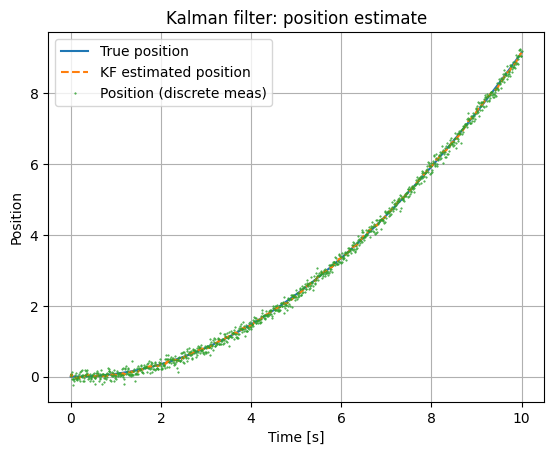

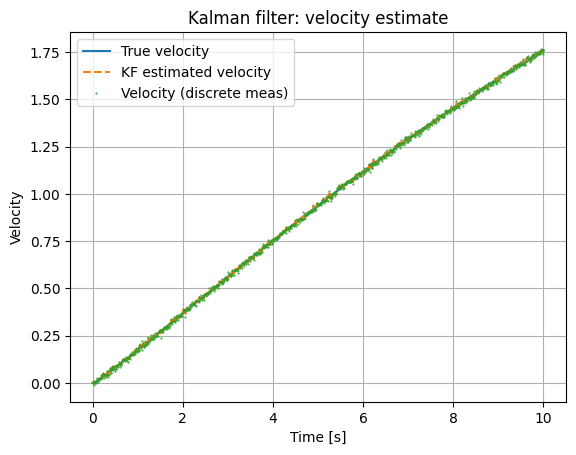

In [789]:
#TODO Plot the results
p_true = x[:, 0]
v_true = x[:, 1]

p_est = x_hat[:, 0]
v_est = x_hat[:, 1]

plt.figure()
plt.plot(t, p_true, label='True position')
plt.plot(t, p_est, '--', label='KF estimated position')
plt.plot(t[mask_p], p_meas[mask_p], 'o', label='Position (discrete meas)', markersize=.5)
plt.xlabel('Time [s]')
plt.ylabel('Position')
plt.title('Kalman filter: position estimate')
plt.grid(True)
plt.legend()

plt.figure()
plt.plot(t, v_true, label='True velocity')
plt.plot(t, v_est, '--', label='KF estimated velocity')
plt.plot(t[mask_v], v_meas[mask_v], 'o', label='Velocity (discrete meas)', markersize=.5)

plt.xlabel('Time [s]')
plt.ylabel('Velocity')
plt.title('Kalman filter: velocity estimate')
plt.grid(True)
plt.legend()

plt.show()

# Extended Kalman Filter



Study the derivation of the Extended Kalman FIlter (EKF) and answer the following questions.

To demonstrate the power of an EKF we use the very common example of the mass pendulum system. This provides a good system to study due to its nonlinear behaviour while being simple to implement. 




1. Starting from the a posteriori state update  
    $\hat{x}_k^+ = \hat{x}_k^- + K_k \big(y_k - c(\hat{x}_k^-)\big),$ 
    show that the “simple” covariance update is  
    $P_k^+ = (I - K_k C_k) P_k^-.$

    Explain why the Joseph form  
    $P_k^+ = (I - K_k C_k)\,P_k^-\,(I - K_k C_k)^\top + K_k R_k K_k^\top$
    is often preferred in numerical implementations.



2.  For a pendulum with state  
    $x = \begin{bmatrix}\theta \\ \dot{\theta}\end{bmatrix},$  
    and dynamics  
    $\dot{\theta} = \dot{\theta}, \qquad \ddot{\theta} = -\frac{g}{\ell}\sin\theta,$ 
    write explicit expressions for:
    - $f(x,u)$  
    - $c(x)$  
    - $F_k = \frac{\partial f}{\partial x}$  
    - $C_k = \frac{\partial c}{\partial x}$  

    needed to implement an EKF that estimates $\theta$ and $\dot{\theta}$ from noisy angle measurements.


3. Explain why the linear Kalman filter is a special case of the extended Kalman filter.  
    Under what conditions does the EKF reduce exactly to the standard Kalman filter?


In [790]:
class ExtendedKalmanFilter(object):
    #Now we build a class for the Extended Kalman Filter
    #This is very similar to the class Kalman Filter which when writing will be easy to compare the similarities

    def __init__(self, x0, P0, Q, R, dt, f_func, F_jac, c_func, C_jac):
        self.x0 = x0
        self.P0 = P0
        self.Q = Q
        self.R = R
        self.dt = dt

        self.f_func = f_func
        self.F_jac = F_jac
        self.c_func = c_func
        self.C_jac = C_jac

        self.time_step = 0

        self.aposteriori = [x0]
        self.apriori = []
        self.Cmatrixaposteriori = [P0]
        self.Cmatrixpriori = []
        self.K_matrix = []
        self.errors = []

    def dt_dynamics(self, xk):
        #TODO Implement Euler discretisation
        f = self.f_func(xk)
        return xk * self.dt*f
    def push_dynamics(self):
        x_plus = self.aposteriori[self.time_step]
        P_plus = self.Cmatrixaposteriori[self.time_step]

        x_minus = self.dt_dynamics(x_plus)

        F_k = self.F_jac(x_plus)
        P_minus = F_k @ P_plus @ F_k.T + self.Q

        self.apriori.append(x_minus)
        self.Cmatrixpriori.append(P_minus)
        self.time_step+=1

    def update_if_measurement(self, measurement):
        if measurement is None:
            self.aposteriori.append(self.apriori[-1])
            self.Cmatrixaposteriori.append(self.Cmatrixpriori[-1])
            return
        self.aposteriori_estimate(measurement)
    def aposteriori_estimate(self, measurement):
        k = self.time_step
        x_minus = self.aposteriori[k-1]
        P_minus = self.Cmatrixpriori[k-1]
        Ck = self.C_jac()

        S = Ck @ P_minus @ Ck.T + self.R
        gain_matrix = P_minus @ Ck.T @ np.linalg.inv(S)

        y_hat = self.c_func(x_minus)
        error = measurement - y_hat
        x_plus = x_minus + gain_matrix@error
        I = np.eye(self.x0.shape[0])
        P_plus = (I - gain_matrix@Ck)@P_minus

        self.K_matrix.append(gain_matrix)
        self.errors.append(error)
        self.aposteriori.append(x_plus)
        self.Cmatrixaposteriori.append(P_plus)
    





In [791]:

dt = 0.01         
T  = 10.0      
N  = int(T/dt)
t  = np.linspace(0, T, N+1)

# no control input 
u = np.zeros(N+1)

# true initial state (theta, omega)
theta0_true = 1.5   # rad
omega0_true = 0.0   # rad/s

x_true = np.zeros((N+1, 2))
x_true[0, :] = [theta0_true, omega0_true]

def pend_f(x):
    theta = x[0,0]
    omega = x[1,0]
    g = 9.81
    l = 1.0
    return np.array([[omega],
                     [-(g/l)*np.sin(theta)]])

for k in range(N):
    xk = x_true[k, :].reshape(2,1)  
    uk = u[k]
    fk = pend_f(xk)
    x_next = xk + dt * fk
    x_true[k+1, :] = x_next.flatten()

rng = np.random.default_rng(0)
sigma_meas = 0.5  # rad

y_meas = x_true[:,0] + rng.normal(0.0, sigma_meas, size=N+1)  





Now implement the EKF into this simulation

In [792]:
def pend_F(x):
    #TODO Implement Jacobian of pend_f
    theta = x[0,0]
    g = 9.81
    l = 1.0
    return np.array([
        [1.0, dt],
        [-(g/l)*np.cos(theta)*dt, 1.0]
    ])

def pend_c(x):
    # measure the angle
    return np.array([[x[0,0]]])  

def pend_C():
    # TODO Implement dh/dx matrix
    return np.array([[1.0, 0.0]])


# initial estimate 
x0 = np.array([[theta0_true + 0.3],
               [omega0_true - 0.5]])

P0 = np.diag([1.0, 1.0])            # initial covariance
Q  = np.diag([1e-3, 1e-3])          # process noise
R  = np.array([[sigma_meas**2]])    # measurement noise covariance

ekf_pend = ExtendedKalmanFilter(x0, P0, Q, R, dt,
                      pend_f, pend_F, pend_c, pend_C)

# storage 
x_hat_ekf = np.zeros((N+1, 2))
x_hat_ekf[0, :] = x0.flatten()

for k in range(N):
    tk = t[k]
    uk = u[k]

    # TODO prediction step
    ekf_pend.push_dynamics()

    # TODO measurement at k+1
    meas = np.array([[y_meas[k+1]]])
    ekf_pend.update_if_measurement(meas)

    # TODO store posterior estimate
    x_hat_ekf[k+1, :] = ekf_pend.aposteriori[-1].flatten()


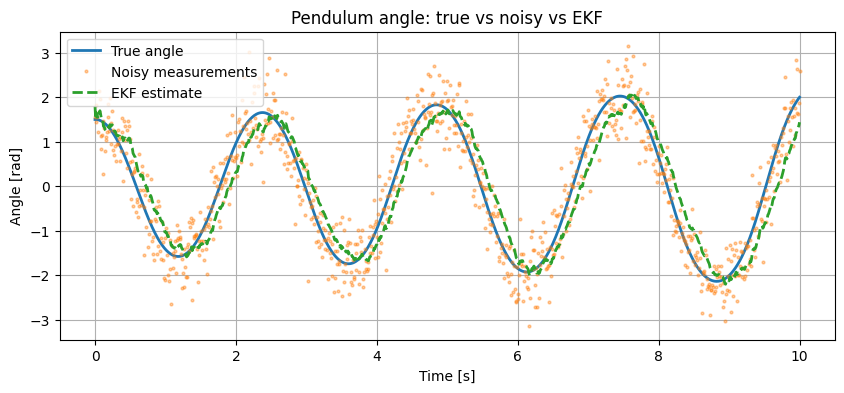

In [793]:

theta_true = x_true[:,0]
omega_true = x_true[:,1]

theta_ekf  = x_hat_ekf[:,0]
omega_ekf  = x_hat_ekf[:,1]

plt.figure(figsize=(10,4))
plt.plot(t, theta_true, label='True angle', linewidth=2)
plt.plot(t, y_meas, '.', label='Noisy measurements', alpha=0.4, markersize=4)
plt.plot(t, theta_ekf, '--', label='EKF estimate', linewidth=2)
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.title('Pendulum angle: true vs noisy vs EKF')
plt.grid(True)
plt.legend()


plt.show()


4. Adjust the process noise and measurement noise to study how the EKF estimate varies. Interpret the results and include a plot in your report.